In [1]:
!pip install -Uqq fastai
!pip install -Uqq librosa

In [2]:
from fastai.data.all import *
from fastai.vision.all import *
import librosa
from IPython.display import Audio
from IPython.utils import io
import re
import itertools
import matplotlib.pyplot as plt
sys.path.append('../')

In [3]:
#path = Path("C:\\Users\\Rango\\Projects\\Lumen\\Dataset\\Dataset\\IRMAS_Training_Data\\")
path = Path("C:\\Users\\Ivkalu\\Documents\\LumenDataset\\Dataset\\IRMAS_Training_Data\\")

get_song_files = FileGetter(extensions='.wav', recurse=True)
files = get_song_files(path)
print(f"(#{len(files)})", files[:6])

(#6705) [Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__1.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__2.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/008__[cel][nod][cla]0058__3.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__1.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__2.wav'), Path('C:/Users/Ivkalu/Documents/LumenDataset/Dataset/IRMAS_Training_Data/cel/012__[cel][nod][cla]0043__3.wav')]


In [4]:
def file_labels(pat: Path):
    r = re.search("\[[^(\[\])]+\]", pat.name)
    if r:
        return [r.group()[1:-1]]
    return []

In [5]:
song_path = path/"cel"/"[cel][cla]0001__1.wav"
file_labels(song_path)

['cel']

In [6]:
y, sr = librosa.load(song_path)

print("Sample rate:", sr)
print("Length of audio time series:", y.shape[0])
print("Time:", librosa.load(song_path)[0].shape[0]/librosa.load(song_path)[1], "s")

Sample rate: 22050
Length of audio time series: 66150
Time: 3.0 s


We can calculate the length of the audio file by dividing the length of audio time series (number of samples) by sample rate (nubmer of samples per second).

# FFT and spectograms

In [7]:
n_fft = 1024
hop_length = 512
f_min = 20
f_max = 8000

def spectogram(song):
    stft = librosa.stft(song, n_fft=n_fft, hop_length=hop_length)
    stft_magnitude, _ = librosa.magphase(stft)
    stft_magnitude_db = librosa.amplitude_to_db(stft_magnitude)
    return stft_magnitude_db
    
song, _ = librosa.load(song_path)
song_fft = np.abs(librosa.stft(song, n_fft=n_fft, hop_length=hop_length))
spec = spectogram(song)

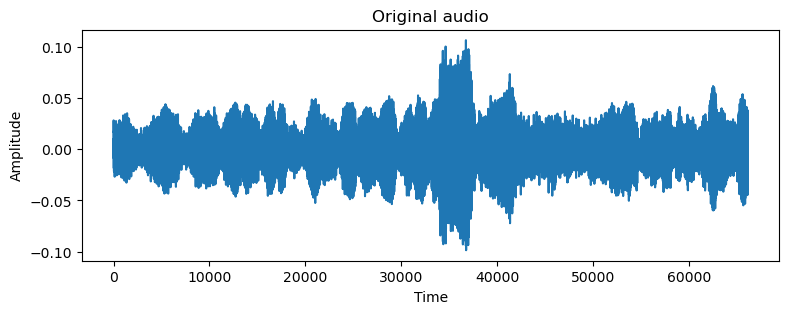

In [127]:
plt.figure(figsize=(9,3))
plt.title('Original audio')
plt.plot(song)
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

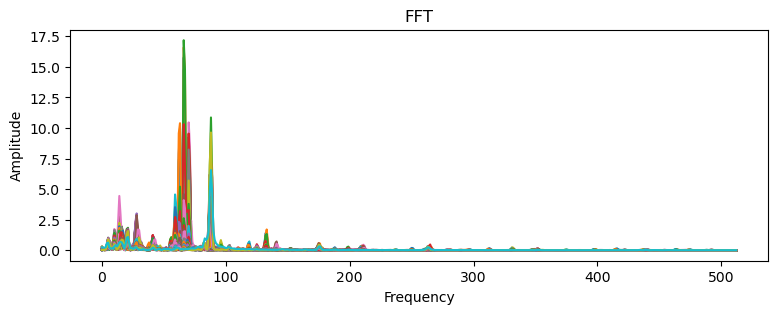

In [128]:
plt.figure(figsize=(9,3))
plt.title('FFT')
plt.plot(song_fft)
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

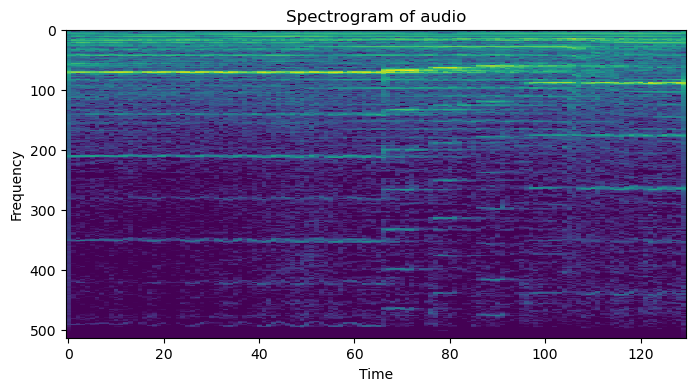

In [12]:
plt.figure(figsize=(8,4))
plt.title('Spectrogram of audio')
plt.imshow(spec, interpolation='nearest', aspect='auto')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# Average model

In [11]:
songsMap = dict()
for song in get_song_files(path):
    label = file_labels(song)
    if label[0] not in songsMap:
        songsMap[label[0]] = []
    songsMap[label[0]].append(song)

In [12]:
MAX_DATA_SIZE = 100
celloAvg = sum(spectogram(librosa.load(song)[0]) for song in songsMap["cel"][:MAX_DATA_SIZE])/MAX_DATA_SIZE

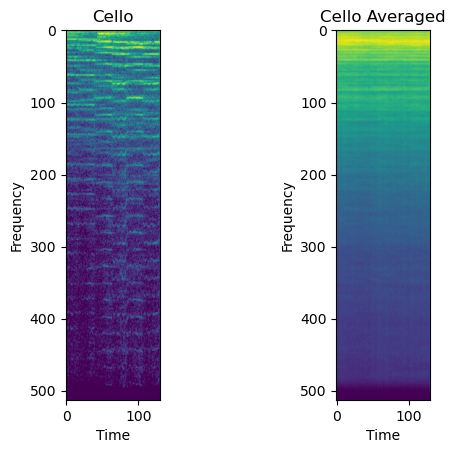

In [129]:
plt.subplot(1,2,1)
plt.title('Cello')
plt.imshow(spectogram(librosa.load(songsMap['cel'][0])[0]))
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Cello Averaged')
plt.imshow(celloAvg)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

In [32]:
class AvgModel:
    def __init__(self):
        pass
        
    def fit(self, X_train, y_train):
        dictionary = {key: [] for key in y_train}
        
        for i in range(len(X_train)):
            dictionary[y_train[i]].append(X_train[i])
        for i in dictionary:
            dictionary[i] = sum(dictionary[i]) / len(dictionary[i])
            
        self.dictionary = dictionary
        return self
        
    def _predict(self, x):
        l = [(np.sum((x-self.dictionary[typee])**2), typee) for typee in self.dictionary]
        return min(l)[1]
        
    def predict(self, X_test):
        predictions = [self._predict(x) for x in X_test]
        return predictions

In [33]:
X = []
y = []
for typee in songsMap:
    for song in songsMap[typee][:MAX_DATA_SIZE]:
        X.append(librosa.load(song)[0])
        y.append(typee)
X = np.array(X)
y = np.array(y)

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

avgModel = AvgModel().fit(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.12947658402203857

In [35]:
X_spec = spectogram(X)
X_train, X_test, y_train, y_test = train_test_split(X_spec, y, test_size=0.33, random_state=42)

avgModel = AvgModel().fit(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.3443526170798898

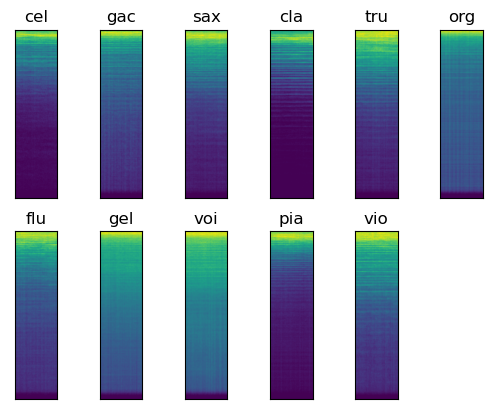

In [36]:
i = 1
for typee in avgModel.dictionary:
    plt.subplot(2,6,i)
    plt.imshow(avgModel.dictionary[typee])
    plt.title(typee)
    plt.xticks([])
    plt.yticks([])
    i+=1
plt.show()

# Spectral centroid

In [19]:
cel, _ = librosa.load(songsMap["cel"][0])
gac, _ = librosa.load(songsMap["gac"][0])
sax, _ = librosa.load(songsMap["sax"][0])

In [50]:
sc_cel = librosa.feature.spectral_centroid(y=cel, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_gac = librosa.feature.spectral_centroid(y=gac, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_sax = librosa.feature.spectral_centroid(y=sax, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]

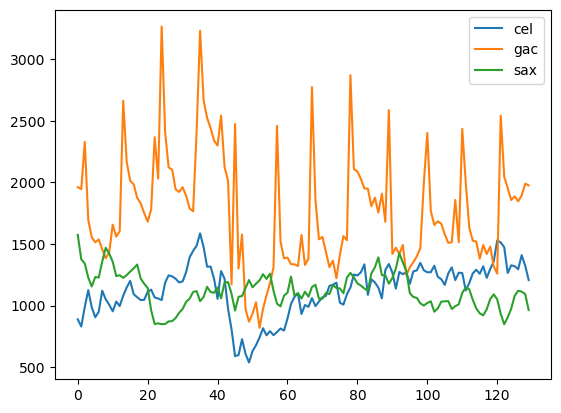

In [21]:
plt.plot(sc_cel, label="cel")
plt.plot(sc_gac, label="gac")
plt.plot(sc_sax, label="sax")
plt.legend()
plt.show()

# Spectral bandwidth

In [22]:
sc_cel = librosa.feature.spectral_bandwidth(y=cel, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_gac = librosa.feature.spectral_bandwidth(y=gac, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
sc_sax = librosa.feature.spectral_bandwidth(y=sax, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]

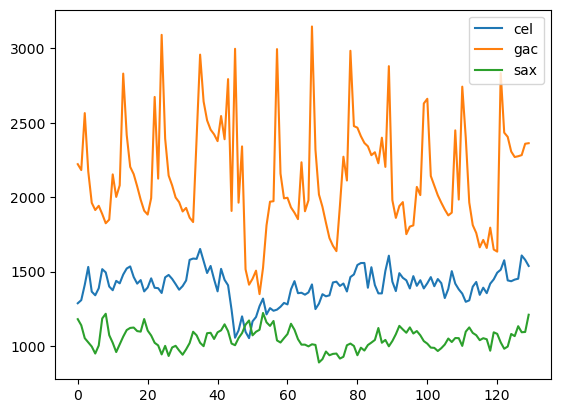

In [23]:
plt.plot(sc_cel, label="cel")
plt.plot(sc_gac, label="gac")
plt.plot(sc_sax, label="sax")
plt.legend()
plt.show()

# Average model with SC

In [24]:
def centroid(song):
    c = librosa.feature.spectral_centroid(y=song, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    return c

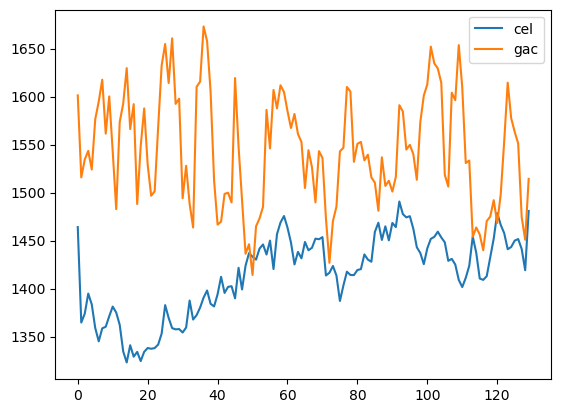

In [25]:
sc_cel_avg = sum(centroid(librosa.load(song)[0]) for song in songsMap["cel"][:MAX_DATA_SIZE])/MAX_DATA_SIZE
sc_gac_avg = sum(centroid(librosa.load(song)[0]) for song in songsMap["gac"][:MAX_DATA_SIZE])/MAX_DATA_SIZE

plt.plot(sc_cel_avg, label="cel")
plt.plot(sc_gac_avg, label="gac")
plt.legend()
plt.show()

In [43]:
X_centroid = np.array([centroid(x) for x in X])
X_train, X_test, y_train, y_test = train_test_split(X_centroid, y, test_size=0.33, random_state=42)

avgModel = AvgModel().fit(X_train, y_train)
accuracy_test = sum(avgModel.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.1928374655647383

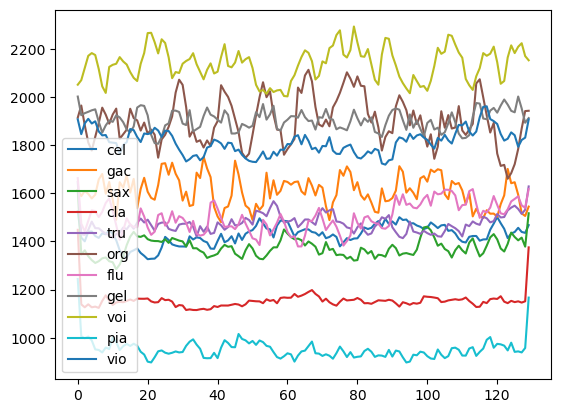

In [27]:
for typee in avgModel.dictionary:
    plt.plot(avgModel.dictionary[typee], label=typee)
plt.legend()
plt.show()

# K-neighbours and Logistic regression

In [45]:
def flatten(X):
    X_mean = np.array([np.sum(x, axis=1)/len(x) for x in X])
    return X_mean

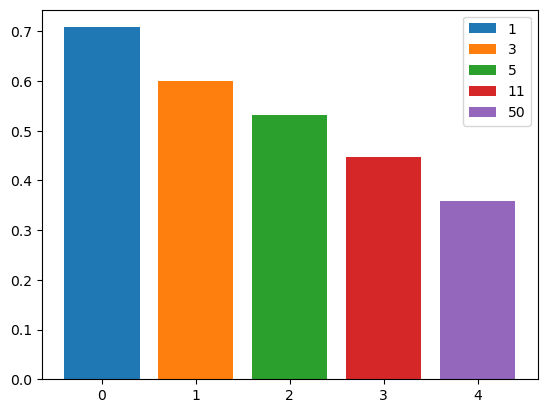

In [72]:
from sklearn.neighbors import KNeighborsClassifier
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

X_flattened = flatten(X_spec)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.33, random_state=42)

i = 0
for n in [1,3,5,11,50]:
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train, y_train)
    accuracy_test = sum(neigh.predict(X_test) == y_test) / len(y_test)
    plt.bar([i],height=[accuracy_test], label=n)
    i+=1
plt.legend()
plt.show()

In [47]:
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.33, random_state=42)

clf = LogisticRegression(random_state=0, max_iter=30, solver='liblinear').fit(X_train, y_train)
accuracy_test = sum(clf.predict(X_test) == y_test) / len(y_test)
accuracy_test

0.6887052341597796

# Conclusion

In [30]:
def bandwidth(song):
    b = librosa.feature.spectral_bandwidth(y=song, sr=sr, n_fft=n_fft, hop_length=hop_length)[0]
    return b

In [102]:
X_fft = np.abs(librosa.stft(X, n_fft=n_fft, hop_length=hop_length))
X_band = np.array([bandwidth(x) for x in X])

clf = LogisticRegression(random_state=0, max_iter=1000, solver='liblinear')
neigh = KNeighborsClassifier(n_neighbors=1)
avgModel = AvgModel()

accuracies = []

for Xi in [X, flatten(X_fft), flatten(X_spec), X_centroid, X_band]:
    X_train, X_test, y_train, y_test = train_test_split(Xi, y, test_size=0.33, random_state=42)
    for model in [avgModel, neigh, clf]:
        model.fit(X_train, y_train)
        accuracy_test = sum(model.predict(X_test) == y_test) / len(y_test)
        accuracies.append(accuracy_test)
    

In [121]:
for Xi in [np.array([np.sum(X_centroid, axis=1)]).T, np.array([np.sum(X_band, axis=1)]).T]:
    for model in [avgModel, neigh, clf]:
        model.fit(X_train, y_train)
        accuracy_test = sum(model.predict(X_test) == y_test) / len(y_test)
        print(accuracy_test)
    

0.12947658402203857
0.1652892561983471
0.16804407713498623
0.12947658402203857
0.1652892561983471
0.16804407713498623


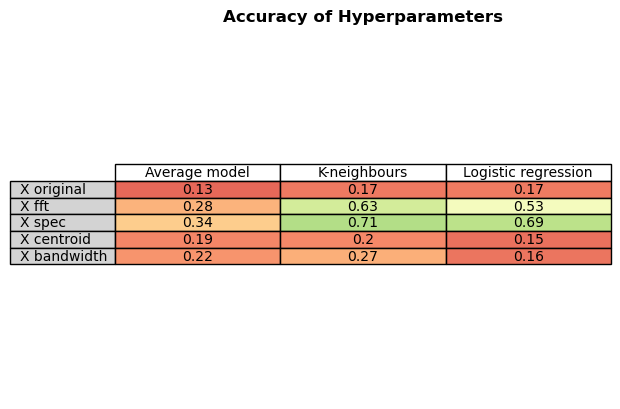

In [103]:
table = np.reshape(accuracies, (5, 3))

# Create a color map where red indicates low accuracy and green indicates high accuracy
cmap = plt.cm.get_cmap('RdYlGn', 256)
norm = plt.Normalize(vmin=0, vmax=1)
colors = cmap(norm(table))
colors[:, :, 3] = 0.8

# Plot the table with colors and labels
fig, ax = plt.subplots()
ax.axis('off')
ax.table(cellText=table.round(2),
         cellColours=colors,
         cellLoc='center',
         rowLabels=['X original', 'X fft', 'X spec', 'X centroid', 'X bandwidth'],
         colLabels=['Average model', 'K-neighbours', 'Logistic regression'],
         rowColours=['lightgray'] * 5,
         loc='center')
plt.title('Accuracy of Hyperparameters', fontweight='bold')
plt.show()